<a href="https://colab.research.google.com/github/Dahlia-Chehata/COVID-19-measures/blob/main/Embedding_Variations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Library imports**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import csv 
import pickle
import bz2
import _pickle as cPickle
import traceback
from functools import partial
from collections import defaultdict

!pip install "tqdm==4.43.0"
!pip install ipdb
import ipdb
from tqdm.contrib.concurrent import process_map

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, random_split, Dataset, DataLoader

!pip install torch-lr-finder

from torch_lr_finder import LRFinder
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

!pip install plotly_express
import plotly_express as px
import plotly.graph_objects as go

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()

!pip install transformers
from transformers import BertTokenizer

import pathlib


     |████████████████████████████████| 61kB 6.0MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
     |████████████████████████████████| 788kB 13.1MB/s 
     |████████████████████████████████| 368kB 22.5MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.7-cp37-none-any.whl size=11434 sha256=89b7869c106cb1e42c0a26d26ed74e406e5b5d3f60104bdf35f08c6873f2aa62
  Stored in directory: /root/.cache/pip/wheels/69/e2/66/bde554f8029ad1c5288f3bf427a78b18ec670182d7e670efe6
Successfully built ipdb
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.18 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.22.0 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation: ipython 5.5.0


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



     |████████████████████████████████| 2.1MB 13.6MB/s 
     |████████████████████████████████| 901kB 59.7MB/s 
     |████████████████████████████████| 3.3MB 59.4MB/s 


# **2. Data Loading and Cleaning**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir = '/content/drive/MyDrive/'

In [ ]:
regulations = pd.read_excel(dir + 'data/acaps_covid19_government_measures_dataset_0.xlsx', sheet_name = 'Dataset')
cases = pd.read_csv(dir + 'data/archive/covid_19_data_updated.csv')

We want to join on Country and Date, but we can see that there are some naming differences between the countries in the `cases` dataset and the `regulations` dataset.

In [ ]:
old = ['Mainland China', 
       'US', 
       'UK', 
       'Saint Vincent and the Grenadines', 
       'Saint Lucia', 
       'Saint Kitts and Nevis',
       'North Macedonia',
       'Congo (Brazzaville)', 
       'Congo (Kinshasa)',
       'Republic of Ireland',
       'North Ireland',
       'West Bank and Gaza',
       'occupied Palestinian territory',
       'Guernsey',
       'Jersey',
       'Channel Islands',
       'Cayman Islands',
       'Diamond Princess',
       'Aruba',
       'Curacao',
       'Saint Martin',
       'St. Martin',
       "('St. Martin',)",
       'Guadeloupe',
       'Martinique',
       'Mayotte',
       'Reunion',
       'Saint Barthelemy',
       'Republic of the Congo',
       'East Timor',
       'Greenland',
       'Faroe Islands',
       'French Guiana',
       'Gibraltar',
       'Gambia, The',
       'The Gambia',
       'Cabo Verde',
       'Guam',
       'Puerto Rico',
       'Macau',
       'MS Zaandam',
       'The Bahamas',
       'Bahamas, The',
       ' Azerbaijan',
       'Vatican City',
       'Burma',
       "Cote d'Ivoire",
       'Korea, South',
       'Republic of Korea',
       'Iran (Islamic Republic of)',
       'Taipei and environs',
       'Taiwan*',
       'Hong Kong SAR',
       'Russian Federation',
       'Czechia',
       'Macao SAR',
       'Viet Nam',
       'Republic of Moldova',
       ]

new = ['China',
       'United States',
       'United Kingdom',
       'St. Vincent and the Grenadines',
       'St. Lucia',
       'St. Kitts and Nevis',
       'Macedonia',
       'Congo',
       'Congo',
       'Ireland',
       'Ireland',
       'Palestine',
       'Palestine',
       'United Kingdom',
       'United Kingdom',
       'United Kingdom',
       'United Kingdom',
       'United Kingdom',
       'Netherlands',
       'Netherlands',
       'France',
       'France',
       'France',
       'France',
       'France',
       'France',
       'France',
       'France',
       'Congo',
       'Timor-Leste',
       'Denmark',
       'Denmark',
       'Denmark',
       'Denmark',
       'Gambia',
       'Gambia',
       'Cape Verde',
       'United States',
       'United States',
       'China',
       'Netherlands',
       'Bahamas',
       'Bahamas',
       'Azerbaijan',
       'Holy See',
       'Myanmar',
       'Ivory Coast',
       'South Korea',
       'South Korea',
       'Iran',
       'Taiwan',
       'Taiwan',
       'Hong Kong',
       'Russia',
       'Czech Republic',
       'China',
       'Vietnam',
       'Moldova',
       ]
cases = cases.replace(old, new)

In [ ]:
old = ['Korea, Republic of',
       'DPRK',
       'DRC',
       'CAR',
       "CÃ´te d'Ivoire",
       'Timor Leste',
       ]

new = ['South Korea',
       'North Korea',
       'Congo',
       'Central African Republic',
       'Ivory Coast',
       'Timor-Leste'
       ]
regulations = regulations.replace(old, new)

Another issue is that the maximum granularity of the `regulations` dataset is `COUNTRY`, but the `cases` dataset is given by `Province/State`. One solution is to sum all cases by `Province/State` to the level of `Country/Region`.

In [ ]:
cases_by_country = cases.groupby(['Country/Region', 'ObservationDate']).sum(['Confirmed', 'Deaths', 'Recovered']).drop(['SNo'], axis = 1)
cases_by_country.reset_index(level=['Country/Region', 'ObservationDate'], inplace=True)

We have that multiple measures were implemented on the same date. Therefore we should concatenate them into a single string.

In [ ]:
dropped_comments = regulations.dropna(subset = ['COMMENTS'])
dropped_categories = regulations.dropna(subset = ['CATEGORY'])

measures = regulations.groupby(['COUNTRY', 'DATE_IMPLEMENTED'])['MEASURE'].apply('. '.join).reset_index()
comments = dropped_comments.groupby(['COUNTRY', 'DATE_IMPLEMENTED'])['COMMENTS'].apply('. '.join).reset_index()
category = dropped_categories.groupby(['COUNTRY', 'DATE_IMPLEMENTED'])['CATEGORY'].apply('. '.join).reset_index()

measures_and_comments = pd.merge(measures, comments, how = 'left')
all = pd.merge(measures_and_comments, category, how = 'left')

If we want to merge the datasets by date, we need to change the format of the `ObservationDate` series in `cases` to a `datetime` type.

In [ ]:
cases_by_country['ObservationDate'] = pd.to_datetime(cases_by_country['ObservationDate'])

In [ ]:
data = pd.merge(all, cases_by_country, left_on = ['COUNTRY', 'DATE_IMPLEMENTED'], right_on = ['Country/Region', 'ObservationDate'], how = 'right')

Assumption to be made is that the last regulation is in place until the next regulation is in place. Therefore we fill missing values using forward fill.

In [ ]:
data = data.sort_values(['Country/Region', 'ObservationDate']).fillna(method = 'ffill')
data = data.groupby('Country/Region').transform(lambda v: v.ffill())

We can drop the duplicate columns:

In [ ]:
data = data.drop(labels = ['DATE_IMPLEMENTED'], axis = 1).dropna(subset = ['MEASURE'])
data = data.sort_values(['COUNTRY', 'ObservationDate'])

This is the final sequential dataset.

In [ ]:
data.to_csv(dir + 'new_cleaned_data.csv', index=False)

# **3. Feature Engineering**

In [ ]:
# load cleaned data
data = pd.read_csv (dir + 'new_cleaned_data.csv')

In [ ]:
data['ObservationDate'] = pd.to_datetime(data['ObservationDate'], errors='coerce')

We want to capture periodicity (daily, monthly and yearly). Therefore we must accurately capture that the distance between December and January for example is the same as the distance between Novemeber and December.

To do this we use sin and cosine transformations.

In [ ]:
data['dayofweek'] = data['ObservationDate'].dt.dayofweek
data['month'] = data['ObservationDate'].dt.month
data['year'] = data['ObservationDate'].dt.year
data['day'] = data['ObservationDate'].dt.day

In [ ]:
data['year_mod'] = (data['year'] - data['year'].min()) / (data['year'].max() - data['year'].min())

In [ ]:
def sin_transform(values):
    return np.sin(2*np.pi*values/len(set(values)))

def cos_transform(values):
    return np.cos(2*np.pi*values/len(set(values)))

In [ ]:
data['dayofweek_sin'] = sin_transform(data['dayofweek'])
data['dayofweek_cos'] = cos_transform(data['dayofweek'])
data['month_sin'] = sin_transform(data['month'])
data['month_cos'] = cos_transform(data['month'])
data['day_sin'] = sin_transform(data['day'])
data['day_cos'] = cos_transform(data['day'])

In [ ]:
data = data.sort_values(['COUNTRY', 'ObservationDate'])

Compute yearly autocorrelation for each timeseries.

In [ ]:
def get_yearly_autocorr(data):
    ac = acf(data, nlags=366, fft=True)
    n = len(ac)
    # print(n)
    if n < 367:
      return (0.5 * ac[n-2]) + (0.25 * ac[n-3]) + (0.25 * ac[n-1]), False
    return (0.5 * ac[365]) + (0.25 * ac[364]) + (0.25 * ac[366]), True

Normalize the data and generate a scale map for the test set. **This is required to run 9.**.

In [ ]:
scale_map = {}
scaled_data = pd.DataFrame()
removal_list = []

for country_id, item_data in tqdm(data.groupby('COUNTRY', as_index=False)):
    
    indexes = data.index[data['COUNTRY'] == country_id].tolist()

    sidata = data.loc[data['COUNTRY'] == country_id, 'Confirmed']
    sidata2 = data.loc[data['COUNTRY'] == country_id, 'Deaths']
    sidata3 = data.loc[data['COUNTRY'] == country_id, 'Recovered']

    mu = sidata.mean()
    sigma = sidata.std()
    yearly_autocorr, keep = get_yearly_autocorr(sidata)

    mu2 = sidata2.mean()
    sigma2 = sidata2.std()

    mu3 = sidata3.mean()
    sigma3 = sidata3.std()

    if not keep:
      #print(indexes)
      removal_list = np.concatenate((removal_list, indexes), axis=0)
    else:
      item_data.loc[:,'Confirmed'] = (item_data['Confirmed'] - mu) / sigma
      if mu2 !=0  and sigma2 != 0:
        item_data.loc[:,'Deaths'] = (item_data['Deaths'] - mu2) / sigma2
      item_data.loc[:,'Recovered'] = (item_data['Recovered'] - mu3) / sigma3
      
      scale_map[country_id] = {'mu': mu, 'sigma': sigma}
      item_data['mean_cases'] = mu
      item_data['yearly_corr'] = yearly_autocorr
      scaled_data = pd.concat([scaled_data, item_data], ignore_index=True)

print(removal_list)
print(scaled_data.isnull().values.sum())

Remove data from countries with fewer than 365 observations.

In [ ]:
print(data.shape)
print(len(np.unique(data['COUNTRY'])))

indexes_to_keep = set(range(data.shape[0])) - set(removal_list)
data = data.take(list(indexes_to_keep))

print(data.shape)
print(len(np.unique(data['COUNTRY'])))

In [ ]:
scaled_data['yearly_corr'] = ((scaled_data['yearly_corr'] - scaled_data['yearly_corr'].mean()) / scaled_data['yearly_corr'].std())

In [ ]:
scaled_data['mean_cases'] = (scaled_data['mean_cases'] - scaled_data['mean_cases'].mean()) / scaled_data['mean_cases'].std()

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
scaled_data = reduce_mem_usage(scaled_data)

In [ ]:
scaled_data.to_pickle(dir + 'new_processed_data_stdscaler2.pkl')

# **4. Data Preprocessing**

## **4.1. Embeddings**

### **4.1.1. Truncated Concatenated Embeddings (BERT)**



In [ ]:
# Load the preprocessed data file 
data = pd.read_csv (dir + 'new_cleaned_data.csv')

In [ ]:
!pip install 'tensorflow==1.15.0'
%tensorflow_version 1.x

!pip install bert-serving-client
!pip install -U bert-serving-server[http]

!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip
!nohup bert-serving-start -max_seq_len 100 -model_dir=./uncased_L-12_H-768_A-12 > out.file 2>&1 &

!ls  # you should see uncased_something_.zip

from bert_serving.client import BertClient
bc = BertClient()

### **4.1.2. Truncated Concatenated Embeddings (BioBERT)**

In [ ]:
!pip install bert-serving-client
!pip install -U bert-serving-server[http]

!wget https://github.com/naver/biobert-pretrained/releases/download/v1.1-pubmed/biobert_v1.1_pubmed.tar.gz
!tar -xvf biobert_v1.1_pubmed.tar.gz
!nohup bert-serving-start -max_seq_len 256 -model_dir=./biobert_v1.1_pubmed > out.file 2>&1 &

!ls  # you should see uncased_something_.zip

from bert_serving.client import BertClient
bc = BertClient()

sentences = data['MEASURE'].tolist()
embedded_text = bc.encode(sentences)

### **4.1.3. Mean Aggregated Embeddings (BERT)**

In [ ]:
import torch
import torch.nn.functional as F

def pad_embeddings(embeddings):
    for index, group in enumerate(embeddings):
        embeddings[index] = F.pad(input=group, pad=(0, 0, 0, 29 - len(group)), mode='constant', value=0)

    return torch.stack(embeddings,0)

sentences = data.MEASURE

def multiple_sentence_embedder(sentences):
    sentence_embeddings = []

    for sentence in sentences:
        separated_sentences = sentence.split(".")
        
        separated_sentences = bc.encode(separated_sentences)
        sentence_embeddings.append(torch.tensor(separated_sentences))

    padded = pad_embeddings(sentence_embeddings)
    return torch.mean(padded, 1)

mean_aggregated_embeddings = multiple_sentence_embedder(sentences)

with open(dir + 'mean_aggregated_embeddings.txt', 'wb') as fp:   #Pickling
  pickle.dump(mean_aggregated_embeddings, fp) 

### **4.1.4. Autoencoder Representation Embeddings (BERT)**

In [ ]:
import torch
import torch.nn.functional as F

def pad_embeddings(embeddings):
    for index, group in enumerate(embeddings):
        embeddings[index] = F.pad(input=group, pad=(0, 0, 0, 29 - len(group)), mode='constant', value=0)

    return torch.stack(embeddings,0)

sentences = data.MEASURE

def multiple_sentence_embedder(sentences):
    sentence_embeddings = []

    for sentence in sentences:
        separated_sentences = sentence.split(".")
        
        separated_sentences = bc.encode(separated_sentences)
        sentence_embeddings.append(torch.tensor(separated_sentences))

    return pad_embeddings(sentence_embeddings)

multiple_sentence_embeddings = multiple_sentence_embedder(sentences)

In [ ]:
paragraph_dataset = TensorDataset(multiple_sentence_embeddings)

batch_size = 8 # 32 creates RAM issues

paragraph_dataloader = DataLoader(
            paragraph_dataset,
            sampler = RandomSampler(paragraph_dataset),
            batch_size = batch_size
        )

In [ ]:
class AE(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.input_shape = input_shape

        self.flatten = nn.Flatten()
        # encoder
        self.encoder1 = nn.Linear(input_shape[1] * input_shape[2], int(input_shape[1] * input_shape[2] / 2))
        self.encoder2 = nn.Linear(int(input_shape[1] * input_shape[2] / 2), int(input_shape[1] * input_shape[2] / 8))
        self.encoder3 = nn.Linear(int(input_shape[1] * input_shape[2] / 8), 768)

        # decoder
        self.decoder1 = nn.Linear(768, int(input_shape[1] * input_shape[2] / 8))
        self.decoder2 = nn.Linear(int(input_shape[1] * input_shape[2] / 8), int(input_shape[1] * input_shape[2] / 2))
        self.decoder3 = nn.Linear(int(input_shape[1] * input_shape[2] / 2), int(input_shape[1] * input_shape[2]))

    def forward(self, sentences):

        out = self.flatten(sentences)
        out = self.encoder1(out)
        out = torch.relu(out)
        out = self.encoder2(out)
        out = torch.relu(out)
        out = self.encoder3(out)
        hidden = torch.relu(out)

        out = self.decoder1(hidden)
        out = torch.relu(out)
        out = self.decoder2(out)
        out = torch.relu(out)
        out = self.decoder3(out)
        out = torch.relu(out)

        return hidden, out.view(-1, self.input_shape[1], self.input_shape[2])

Train autoencoder.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AE(input_shape=(batch_size, 29, 768)).to(device)

from torch.optim import Adam
optimizer = optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.MSELoss()

In [ ]:
epochs = 4

for epoch in range(epochs):
    loss = 0
    for batch in paragraph_dataloader:
        paragraph_b = batch[0].to(device)
        
        optimizer.zero_grad()
        
        _, out = model(paragraph_b)
        train_loss = criterion(out, paragraph_b)
        
        train_loss.backward()
        optimizer.step()
        
        loss += train_loss.item()
    
    loss = loss / len(paragraph_dataloader)
    
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

In [ ]:
torch.save(model.state_dict(), dir + "autoencoder_4_epochs.pkl")

In [ ]:
model = AE(input_shape=(batch_size, 29, 768))
model.load_state_dict(torch.load(dir + "autoencoder_4_epochs.pkl"))

#### **4.1.4.1. Calculate autoencoded embeddings.**

In [ ]:
model.eval()

autoencoded_embeddings = []

for batch in paragraph_dataloader:
    paragraph_b = batch[0].to(device)
    
    with torch.no_grad():
        hidden, _ = model(paragraph_b)
    autoencoded_embeddings.append(hidden)

autoencoded_embeddings = torch.cat(autoencoded_embeddings)

with open(dir + 'autoencoded_embeddings.txt', 'wb') as fp:   #Pickling
  pickle.dump(autoencoded_embeddings, fp) 

## **4.2. Sequence Generation**
This subsection needs to be run locally due to Colab RAM limitations.

In [ ]:
# Multiprocessing

def _apply_df(args):
    df, func, key_column = args
    result = df.groupby(key_column).progress_apply(func)
    return result

def almost_equal_split(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg
    return out


def mp_apply(df, func, key_column):
    workers = 8
    key_splits = almost_equal_split(df[key_column].unique(), workers) # split by the number of COUNTRY
    split_dfs = [df[df[key_column].isin(key_list)] for key_list in key_splits]
    result = process_map(_apply_df, [(d, func, key_column) for d in split_dfs], max_workers=workers)
    return pd.concat(result)

In [ ]:
# split a multivariate sequence into samples
def split_sequences(group_data, 
                    n_steps_in, 
                    n_steps_out, 
                    x_cols, 
                    y_cols, 
                    additional_columns, 
                    step=1, 
                    lag_fns=[]):
  
    X, y = list(), list()
    additional_col_map = defaultdict(list)
    group_data = group_data.sort_values('ObservationDate')
    
    for i, lag_fn in enumerate(lag_fns):
        group_data[f'lag_{i}'] = lag_fn(group_data[y_cols[0]])
    
    steps = list(range(0, len(group_data), step))
    if step != 1 and steps[-1] != (len(group_data) - 1):
        steps.append((len(group_data) - 1))
    
    for i in steps:
        # find the end of this pattern
        in_end_idx = i + n_steps_in
        out_end_idx = in_end_idx + n_steps_out
        # check if we are beyond the dataset
        if out_end_idx > len(group_data):
            break
        # gather input and output parts of the pattern
        if len(x_cols) == 1:
            x_cols = x_cols[0]
        seq_x = group_data.iloc[i:in_end_idx, :][x_cols].values
        seq_y = group_data.iloc[in_end_idx:out_end_idx, :][y_cols + [f'lag_{i}' for i in range(len(lag_fns))]].values
    
        for col in additional_columns:
            additional_col_map[col].append(group_data.iloc[in_end_idx][col])
        
        X.append(seq_x)
        y.append(seq_y)
       
    
    additional_column_items = sorted(additional_col_map.items(), key=lambda x: x[0])
    return (np.array(X), np.array(y), *[i[1] for i in additional_column_items])

In [ ]:
def sequence_builder(data, 
                     n_steps_in,
                     n_steps_out, 
                     key_column, 
                     x_cols, 
                     y_col, 
                     y_cols, 
                     additional_columns, 
                     diff=False, 
                     lag_fns=[], 
                     step=1):
    
    # first entry in y_cols should be the target variable
    sequence_fn = partial(split_sequences,
                          n_steps_in=n_steps_in,
                          n_steps_out=n_steps_out,
                          x_cols=x_cols,
                          y_cols=y_cols,
                          additional_columns=list(set([key_column] + additional_columns)),
                          lag_fns=lag_fns,
                          step=step
                          )
    sequence_data = mp_apply(data[list(set([key_column] + x_cols + y_cols + additional_columns))],
                              sequence_fn,
                              key_column
                            )
    sequence_data = pd.DataFrame(sequence_data, columns=['result'])
    s = sequence_data.apply(lambda x: pd.Series(zip(*[col for col in x['result']])), axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'result'
    sequence_data = sequence_data.drop('result', axis=1).join(s)
    sequence_data['result'] = pd.Series(sequence_data['result'])
    sequence_data[['x_sequence', 'y_sequence'] + sorted(set([key_column] + additional_columns))] = pd.DataFrame(sequence_data.result.values.tolist(), index=sequence_data.index)
    
    sequence_data.drop('result', axis=1, inplace=True)
    
    if key_column in sequence_data.columns:
        sequence_data.drop(key_column, axis=1, inplace=True)
    sequence_data = sequence_data.reset_index()
    print('Shape of sequence data:', sequence_data.shape)
    sequence_data = sequence_data[~sequence_data['x_sequence'].isnull()]
    return sequence_data


In [ ]:
def last_year_lag(col): 
  return (col.shift(364) * 0.25) + (col.shift(365) * 0.5) + (col.shift(366) * 0.25).fillna(0)

Load the scaled data

In [ ]:
data = pd.read_pickle(dir + 'new_processed_data_stdscaler2.pkl')

Join the embeddings as 768 features in the dataframe

In [ ]:
emb_colname = []
for i in range(len(embeddings.T)):
  data ['Embedded_MEASURE_'+ str(i+1)] = embeddings.T[i]
  emb_colname.append('Embedded_MEASURE_'+ str(i+1))

In [ ]:
n_out = 15
n_in = 30

In [ ]:
#TODO: add category, comments in additional columns
sequence_data = sequence_builder(
                  data=data, 
                  n_steps_in=n_in, 
                  n_steps_out=n_out, 
                  key_column='COUNTRY', 
                  x_cols=['Confirmed', 'Deaths', 'Recovered', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'year_mod', 'day_sin', 'day_cos'] + emb_colname, 
                  y_col='Confirmed', 
                  y_cols=['Confirmed', 'Deaths', 'Recovered', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'year_mod', 'day_sin', 'day_cos'] + emb_colname,
                  additional_columns=['MEASURE', 'ObservationDate', 'yearly_corr'], 
                  lag_fns=[last_year_lag]
)

sequence_data.to_pickle(dir + 'sequence_data_biobert_embeddings_30in15out.pkl')


# **5. Data loading and train-test splitting**

In [ ]:
# Load memory-reduced compressed pickle file
def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

sequence_data = decompress_pickle(dir + 'new_sequence_data_stdscaler_test_bio_emb_30_15_2.pbz2') 

In [ ]:
lag_null_filter = sequence_data['y_sequence'].apply(lambda val: np.isnan(val[:, -1].reshape(-1)).sum() == 0)
sequence_data.loc[lag_null_filter, 'ObservationDate'].min()

Timestamp('2020-02-20 00:00:00')

In [ ]:
#Split data 
min_date = sequence_data.ObservationDate.min()
max_date = sequence_data.ObservationDate.max()

date_diff = max_date - min_date

train_split = min_date + date_diff * 0.9

print(train_split)

# Assign 90% of the data to training (this cannot be random)
train = sequence_data[sequence_data.ObservationDate <= train_split]
test = sequence_data[sequence_data.ObservationDate > train_split]

print(train.shape)
print(test.shape)

2021-02-22 02:24:00
(59368, 6)
(6272, 6)


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, cat_columns=[], num_columns=[], embed_vector_size=None, decoder_input=True, ohe_cat_columns=False):
        super().__init__()
        self.sequence_data = None
        self.cat_columns = cat_columns # categorical features
        self.num_columns = num_columns # numerical/ static features
        self.cat_classes = {}
        self.cat_embed_shape = []
        self.cat_embed_vector_size = embed_vector_size if embed_vector_size is not None else {}
        self.pass_decoder_input=decoder_input
        self.ohe_cat_columns = ohe_cat_columns
        self.cat_columns_to_decoder = False

    def get_embedding_shape(self):
        return self.cat_embed_shape

    def load_sequence_data(self, processed_data):
        self.sequence_data = processed_data

    def process_cat_columns(self, column_map=None):
        column_map = column_map if column_map is not None else {}
        # print(column_map)
        for col in self.cat_columns:
            # print(col)
            self.sequence_data[col] = self.sequence_data[col].astype('category')
            # print(self.sequence_data[col])
            if col in column_map:
                self.sequence_data[col] = self.sequence_data[col].cat.set_categories(column_map[col]).fillna('#NA#')
                print(self.sequence_data[col])
                # print('yes')
            else:
                self.sequence_data[col].cat.add_categories('#NA#', inplace=True)
                print(self.sequence_data[col])
                # print('no')
            
            self.cat_embed_shape.append((len(self.sequence_data[col].cat.categories), self.cat_embed_vector_size.get(col, 5)))
            print(self.cat_embed_shape)
    
    def __len__(self):
        return len(self.sequence_data)

    def __getitem__(self, idx):
        row = self.sequence_data.iloc[[idx]]
        # print(row.shape)
        # print(row['x_sequence'].values[0].shape)
        x_inputs = [torch.tensor(row['x_sequence'].values[0], dtype=torch.float32)]
        y = torch.tensor(row['y_sequence'].values[0], dtype=torch.float32)
        if self.pass_decoder_input:
            decoder_input = torch.tensor(row['y_sequence'].values[0][:, 1:], dtype=torch.float32)
        if len(self.num_columns) > 0:
            for col in self.num_columns:
                num_tensor = torch.tensor([row[col].values[0]], dtype=torch.float32)
                x_inputs[0] = torch.cat((x_inputs[0], num_tensor.repeat(x_inputs[0].size(0)).unsqueeze(1)), axis=1)
                decoder_input = torch.cat((decoder_input, num_tensor.repeat(decoder_input.size(0)).unsqueeze(1)), axis=1)
        if len(self.cat_columns) > 0:
            if self.ohe_cat_columns:
                for ci, (num_classes, _) in enumerate(self.cat_embed_shape):
                    col_tensor = torch.zeros(num_classes, dtype=torch.float32)
                    col_tensor[row[self.cat_columns[ci]].cat.codes.values[0]] = 1.0
                    col_tensor_x = col_tensor.repeat(x_inputs[0].size(0), 1)
                    x_inputs[0] = torch.cat((x_inputs[0], col_tensor_x), axis=1)
                    if self.pass_decoder_input and self.cat_columns_to_decoder:
                        col_tensor_y = col_tensor.repeat(decoder_input.size(0), 1)
                        decoder_input = torch.cat((decoder_input, col_tensor_y), axis=1)
            else:
                cat_tensor = torch.tensor([row[col].cat.codes.values[0] for col in self.cat_columns],dtype=torch.long)
                x_inputs.append(cat_tensor)
        if self.pass_decoder_input:
            x_inputs.append(decoder_input)
            y = torch.tensor(row['y_sequence'].values[0][:, 0], dtype=torch.float32)
        if len(x_inputs) > 1:
            return tuple(x_inputs), y
        return x_inputs[0], y

In [ ]:
train_with_MEASURE = train
test_with_MEASURE = test

train = train_with_MEASURE.drop('MEASURE', 1)
test = test_with_MEASURE.drop('MEASURE', 1)

In [ ]:
train_dataset = CustomDataset(cat_columns=['COUNTRY'], num_columns=['yearly_corr'], embed_vector_size={'COUNTRY': 5}, ohe_cat_columns=True)
test_dataset = CustomDataset(cat_columns=['COUNTRY'], num_columns=['yearly_corr'], embed_vector_size={'COUNTRY': 5}, ohe_cat_columns=True)

In [ ]:
train_dataset.load_sequence_data(train)
test_dataset.load_sequence_data(test)

In [ ]:
cat_map = train_dataset.process_cat_columns()
# print (cat_map)
test_dataset.process_cat_columns(cat_map)

In [ ]:
batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
print(len(train_dataloader), len(test_dataloader))

464 49


In [ ]:
(X_con, X_dec), y = next(iter(train_dataloader))
X_con.shape, y.shape, X_dec.shape

(torch.Size([128, 30, 956]), torch.Size([128, 15]), torch.Size([128, 15, 779]))

In [ ]:
encoder_feature_len = X_con.shape[2]
decoder_feature_len = X_dec.shape[2] + 1

# **6. Seq2seq Model**

In [ ]:
torch.manual_seed(420)
np.random.seed(420)

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


## **6.1. Encoder-Decoder**

### **6.1.1. GRU-based Encoder-Decoder**

In [ ]:
class GRUEncoderDecoderWrapper(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder_cell, 
                 output_size=3, 
                 teacher_forcing=0.3, 
                 sequence_len=336, 
                 decoder_input=True, 
                 device='cpu',
                 attention=False):
      
        super().__init__()
        self.encoder = encoder
        self.decoder_cell = decoder_cell
        self.output_size = output_size
        self.teacher_forcing = teacher_forcing
        self.sequence_length = sequence_len
        self.decoder_input = decoder_input
        self.device = device
        self.attention=attention

    def forward(self, xb, yb=None):
        if self.decoder_input:
            decoder_input = xb[-1]
            input_seq = xb[0]
            if len(xb) > 2:
                encoder_output, encoder_hidden = self.encoder(input_seq, *xb[1:-1])
            else:
                encoder_output, encoder_hidden = self.encoder(input_seq)
        else:
            if type(xb) is list and len(xb) > 1:
                input_seq = xb[0]
                encoder_output, encoder_hidden = self.encoder(*xb)
            else:
                input_seq = xb
                encoder_output, encoder_hidden = self.encoder(input_seq)
        prev_hidden = encoder_hidden
        outputs = torch.zeros(input_seq.size(0), self.output_size, device=self.device)
        y_prev = input_seq[:, -1, 0].unsqueeze(1)
        for i in range(self.output_size):
            step_decoder_input = torch.cat((y_prev, decoder_input[:, i]), axis=1)
            if (yb is not None) and (i > 0) and (torch.rand(1) < self.teacher_forcing):
                step_decoder_input = torch.cat((yb[:, i].unsqueeze(1), decoder_input[:, i]), axis=1)
            if self.attention:
              rnn_output, prev_hidden = self.decoder_cell(encoder_output, prev_hidden, step_decoder_input)
            else:
              rnn_output, prev_hidden = self.decoder_cell(prev_hidden, step_decoder_input)
            y_prev = rnn_output
            outputs[:, i] = rnn_output.squeeze(1)
        return outputs

### **6.1.2. LSTM-based Encoder-Decoder**

In [ ]:
class LSTMEncoderDecoderWrapper(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder_cell, 
                 output_size=3, 
                 teacher_forcing=0.3, 
                 sequence_len=336, 
                 decoder_input=True, 
                 device='cpu',
                 attention=False):
      
        super().__init__()
        self.encoder = encoder
        self.decoder_cell = decoder_cell
        self.output_size = output_size
        self.teacher_forcing = teacher_forcing
        self.sequence_length = sequence_len
        self.decoder_input = decoder_input
        self.device = device
        self.attention=attention

    def forward(self, xb, yb=None):
        if self.decoder_input:
            decoder_input = xb[-1]
            input_seq = xb[0]
            if len(xb) > 2:
                encoder_output, (encoder_hidden, encoder_cell) = self.encoder(input_seq, *xb[1:-1])
            else:
                encoder_output, (encoder_hidden, encoder_cell) = self.encoder(input_seq)
        else:
            if type(xb) is list and len(xb) > 1:
                input_seq = xb[0]
                encoder_output, (encoder_hidden, encoder_cell) = self.encoder(*xb)
            else:
                input_seq = xb
                encoder_output, (encoder_hidden, encoder_cell) = self.encoder(input_seq)
        prev_hidden = encoder_hidden
        prev_cell = encoder_cell
        outputs = torch.zeros(input_seq.size(0), self.output_size, device=self.device)
        y_prev = input_seq[:, -1, 0].unsqueeze(1)
        for i in range(self.output_size):
            step_decoder_input = torch.cat((y_prev, decoder_input[:, i]), axis=1)
            if (yb is not None) and (i > 0) and (torch.rand(1) < self.teacher_forcing):
                step_decoder_input = torch.cat((yb[:, i].unsqueeze(1), decoder_input[:, i]), axis=1)
            if self.attention:
              rnn_output, prev_hidden, prev_cell = self.decoder_cell(encoder_output, prev_hidden, prev_cell, step_decoder_input)
            else:
              rnn_output, prev_hidden, prev_cell = self.decoder_cell(prev_hidden, prev_cell, step_decoder_input)
            y_prev = rnn_output
            outputs[:, i] = rnn_output.squeeze(1)
        return outputs

## **6.2. Encoder**

### **6.2.1. GRU-based Encoder**

In [ ]:
class RNNEncoderGRU(nn.Module):
    def __init__(self, 
                 rnn_num_layers=1, 
                 input_feature_len=1, 
                 sequence_len=168, 
                 hidden_size=100, 
                 bidirectional=False, 
                 device='cpu', 
                 rnn_dropout=0.2):
      
        super().__init__()
        self.sequence_len = sequence_len
        self.hidden_size = hidden_size
        self.input_feature_len = input_feature_len
        self.num_layers = rnn_num_layers
        self.rnn_directions = 2 if bidirectional else 1
        self.cell = nn.GRU(
            input_size=input_feature_len,
            num_layers=rnn_num_layers,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=rnn_dropout
        )
        self.device = device

    def forward(self, input_seq):
        ht = torch.zeros(self.num_layers * self.rnn_directions, input_seq.size(0), self.hidden_size, device=self.device)
        if input_seq.ndim < 3:
            input_seq.unsqueeze_(2)
        gru_out, hidden = self.cell(input_seq, ht)
        # print(gru_out.shape)
        # print(hidden.shape)
        if self.rnn_directions * self.num_layers > 1:
            num_layers = self.rnn_directions * self.num_layers
            if self.rnn_directions > 1:
                gru_out = gru_out.view(input_seq.size(0), self.sequence_len, self.rnn_directions, self.hidden_size)
                gru_out = torch.sum(gru_out, axis=2)
            hidden = hidden.view(self.num_layers, self.rnn_directions, input_seq.size(0), self.hidden_size)  
            if self.num_layers > 0:
                hidden = hidden[-1]
            else:
                hidden = hidden.squeeze(0)
            hidden = hidden.sum(axis=0)
        else:
            hidden.squeeze_(0)
        return gru_out, hidden

#### **6.2.1.1. Unidirectional GRU-based Encoder**

In [ ]:
uni_gru_encoder = RNNEncoderGRU(
    input_feature_len=encoder_feature_len, 
    rnn_num_layers=1, 
    hidden_size=100,  
    sequence_len=n_in,
    bidirectional=False,
    device=device,
    rnn_dropout=0.2
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



#### **6.2.1.2. Bidirectional GRU-based Encoder**

In [ ]:
bi_gru_encoder = RNNEncoderGRU(
    input_feature_len=encoder_feature_len, 
    rnn_num_layers=1, 
    hidden_size=100,  
    sequence_len=n_in,
    bidirectional=True,
    device=device,
    rnn_dropout=0.2
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



### **6.2.2. LSTM-based Encoder**

In [ ]:
class RNNEncoderLSTM(nn.Module):
    def __init__(self, 
                 rnn_num_layers=1, 
                 input_feature_len=1, 
                 sequence_len=168, 
                 hidden_size=100, 
                 bidirectional=False, 
                 device='cpu', 
                 rnn_dropout=0.2):
      
        super().__init__()
        self.sequence_len = sequence_len
        self.hidden_size = hidden_size
        self.input_feature_len = input_feature_len
        self.num_layers = rnn_num_layers
        self.rnn_directions = 2 if bidirectional else 1
        self.cell = nn.LSTM(
            num_layers=rnn_num_layers,
            input_size=input_feature_len,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=rnn_dropout
        )
        self.device = device

    def forward(self, input_seq):
        ht = torch.zeros(self.num_layers * self.rnn_directions, input_seq.size(0), self.hidden_size, device=self.device)
        ct = torch.zeros(self.num_layers * self.rnn_directions, input_seq.size(0), self.hidden_size, device=self.device)
        if input_seq.ndim < 3:
            input_seq.unsqueeze_(2)
        lstm_out, (hidden, context) = self.cell(input_seq, (ht, ct))
        if self.rnn_directions * self.num_layers > 1:
            num_layers = self.rnn_directions * self.num_layers
            if self.rnn_directions > 1:
                lstm_out = lstm_out.view(input_seq.size(0), self.sequence_len, self.rnn_directions, self.hidden_size)
                lstm_out = torch.sum(lstm_out, axis=2)
            hidden = hidden.view(self.num_layers, self.rnn_directions, input_seq.size(0), self.hidden_size)
            context = context.view(self.num_layers, self.rnn_directions, input_seq.size(0), self.hidden_size)  
            if self.num_layers > 0:
                hidden = hidden[-1]
                context = context[-1]
            else:
                hidden = hidden.squeeze(0)
                context = context.squeeze(0)
            hidden = hidden.sum(axis=0)
            context = context.sum(axis=0)
        else:
            hidden.squeeze_(0)
            context.squeeze_(0)
        return lstm_out, (hidden, context)

#### **6.2.2.1. Unidirectional LSTM-based Encoder**

In [ ]:
uni_lstm_encoder = RNNEncoderLSTM(
    input_feature_len=encoder_feature_len, 
    rnn_num_layers=1, 
    hidden_size=100,  
    sequence_len=n_in,
    bidirectional=False,
    device=device,
    rnn_dropout=0.2
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



#### **6.2.2.2. Bidirectional LSTM-based Encoder**

In [ ]:
bi_lstm_encoder = RNNEncoderLSTM(
    input_feature_len=encoder_feature_len, 
    rnn_num_layers=1, 
    hidden_size=100,  
    sequence_len=n_in,
    bidirectional=True,
    device=device,
    rnn_dropout=0.2,
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



## **6.3. Decoder**

### **6.3.1. Decoder without attention**

#### **6.3.1.1. GRU-based Decoder without attention**

In [ ]:
class GRUDecoderCell(nn.Module):
    def __init__(self, input_feature_len, hidden_size, dropout=0.2):
        super().__init__()
        self.decoder_rnn_cell = nn.GRUCell(
            input_size=input_feature_len,
            hidden_size=hidden_size,
        )
        self.out = nn.Linear(hidden_size, 1)
        self.attention = False
        self.dropout = nn.Dropout(dropout)

    def forward(self, prev_hidden, y):
        rnn_hidden = self.decoder_rnn_cell(y, prev_hidden)
        output = self.out(rnn_hidden)
        return output, self.dropout(rnn_hidden)

In [ ]:
gru_wo_decoder = GRUDecoderCell(
    input_feature_len=decoder_feature_len,
    hidden_size=100,
)

#### **6.3.1.2. LSTM-based Decoder without Attention**

In [ ]:
class LSTMDecoderCell(nn.Module):
    def __init__(self, input_feature_len, hidden_size, dropout=0.2):
        super().__init__()
        self.decoder_rnn_cell = nn.LSTMCell(
            input_size=input_feature_len,
            hidden_size=hidden_size,
        )
        self.out = nn.Linear(hidden_size, 1)
        self.attention = False
        self.dropout = nn.Dropout(dropout)

    def forward(self, prev_hidden, prev_cell, y):
        rnn_hidden, rnn_cell = self.decoder_rnn_cell(y, (prev_hidden, prev_cell))
        output = self.out(rnn_hidden)
        return output, self.dropout(rnn_hidden), self.dropout(rnn_cell)

In [ ]:
lstm_wo_decoder = LSTMDecoderCell(
    input_feature_len=decoder_feature_len,
    hidden_size=100,
)

### **6.3.2. Decoder with Attention**

#### **6.3.2.1. GRU-based Decoder with Attention**

In [ ]:
class GRUAttentionDecoderCell(nn.Module):
    def __init__(self, input_feature_len, hidden_size, sequence_len, dropout=0.2):
        super().__init__()
        # attention - inputs - (decoder_inputs, prev_hidden)
        self.attention_linear = nn.Linear(hidden_size + input_feature_len, sequence_len)
        self.attention = True
        # attention_combine - inputs - (decoder_inputs, attention * encoder_outputs)
        self.decoder_rnn_cell = nn.GRUCell(
            input_size=hidden_size,
            hidden_size=hidden_size,
        )
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, encoder_output, prev_hidden, y):
        attention_input = torch.cat((prev_hidden, y), axis=1)
        attention_weights = F.softmax(self.attention_linear(attention_input)).unsqueeze(1)
        # print(attention_weights.shape)
        # print(encoder_output.shape)
        attention_combine = torch.bmm(attention_weights, encoder_output).squeeze(1)
        rnn_hidden = self.decoder_rnn_cell(attention_combine, prev_hidden)
        output = self.out(rnn_hidden)
        return output, self.dropout(rnn_hidden)

In [ ]:
gru_w_decoder = GRUAttentionDecoderCell(
    input_feature_len=decoder_feature_len,
    hidden_size=100,
    sequence_len=n_in
)

#### **6.3.2.2. LSTM-based Decoder with Attention**

In [ ]:
class LSTMAttentionDecoderCell(nn.Module):
    def __init__(self, input_feature_len, hidden_size, sequence_len, dropout=0.2):
        super().__init__()
        # attention - inputs - (decoder_inputs, prev_hidden)
        self.attention_linear = nn.Linear(hidden_size + input_feature_len, sequence_len)
        self.attention = True
        # attention_combine - inputs - (decoder_inputs, attention * encoder_outputs)
        self.decoder_rnn_cell = nn.LSTMCell(
            input_size=hidden_size,
            hidden_size=hidden_size,
        )
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, encoder_output, prev_hidden, prev_cell, y):
        attention_input = torch.cat((prev_hidden, y), axis=1)
        attention_weights = F.softmax(self.attention_linear(attention_input)).unsqueeze(1)
        # print(attention_weights.shape)
        # print(encoder_output.shape)
        attention_combine = torch.bmm(attention_weights, encoder_output).squeeze(1)
        rnn_hidden, rnn_cell = self.decoder_rnn_cell(attention_combine, (prev_hidden, prev_cell))
        output = self.out(rnn_hidden)
        return output, self.dropout(rnn_hidden), self.dropout(rnn_cell)

In [ ]:
lstm_w_decoder = LSTMAttentionDecoderCell(
    input_feature_len=decoder_feature_len,
    hidden_size=100,
    sequence_len=n_in,
)

# **7. Training**

In [ ]:
def save_dict(path, name, _dict):
    with open(path/f'{name}.pickle', 'wb') as handle:
        pickle.dump(_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

class TorchTrainer():
    def __init__(self, name, model, optimizer, loss_fn, scheduler, device, **kwargs):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.loss_fn = loss_fn
        self.device = device
        self.name = name
        self.checkpoint_path = pathlib.Path(kwargs.get('checkpoint_folder', dir + f'models/{name}_chkpts'))
        self.checkpoint_path.mkdir(parents=True, exist_ok=True)
        self.train_checkpoint_interval = kwargs.get('train_checkpoint_interval', 1)
        self.max_checkpoints = kwargs.get('max_checkpoints', 25)
        self.writer = SummaryWriter(dir + f'runs/{name}')
        self.scheduler_batch_step = kwargs.get('scheduler_batch_step', False)
        self.additional_metric_fns = kwargs.get('additional_metric_fns', {})
        self.additional_metric_fns = self.additional_metric_fns.items()
        self.pass_y = kwargs.get('pass_y', False)
        self.valid_losses = {}
        
    def _get_checkpoints(self, name=None):
        checkpoints = []
        checkpoint_path = self.checkpoint_path if name is None else pathlib.Path(dir + f'models/{name}_chkpts')
        for cp in self.checkpoint_path.glob('checkpoint_*'):
            checkpoint_name = str(cp).split('/')[-1]
            checkpoint_epoch = int(checkpoint_name.split('_')[-1])
            checkpoints.append((cp, checkpoint_epoch))
        checkpoints = sorted(checkpoints, key=lambda x: x[1], reverse=True)
        #self.valid_losses = pd.read_pickle(self.checkpoint_path/'valid_losses.pickle')
        return checkpoints

    def _clean_outdated_checkpoints(self):
        checkpoints = self._get_checkpoints()
        if len(checkpoints) > self.max_checkpoints:
            checkpoints = sorted(checkpoints, key=lambda x: x[1], reverse=True)
            for delete_cp in checkpoints[self.max_checkpoints:]:
                delete_cp[0].unlink()
                print(f'removed checkpoint of epoch - {delete_cp[1]}')

    def _save_checkpoint(self, epoch, valid_loss=None):
        self._clean_outdated_checkpoints()
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': [o.state_dict() for o in self.optimizer] if type(self.optimizer) is list else self.optimizer.state_dict(),
        }
        if self.scheduler is not None:
            checkpoint.update({
                'scheduler_state_dict': [o.state_dict() for o in self.scheduler] if type(self.scheduler) is list else self.scheduler.state_dict()
            })
        if valid_loss:
            checkpoint.update({'loss': valid_loss})
        torch.save(checkpoint, self.checkpoint_path/f'checkpoint_{epoch}')
        save_dict(self.checkpoint_path, 'valid_losses', self.valid_losses)
        print(f'saved checkpoint for epoch {epoch}')
        self._clean_outdated_checkpoints()

    def _load_checkpoint(self, epoch=None, only_model=False, name=None):
        if name is None:
            checkpoints = self._get_checkpoints()
        else:
            checkpoints = self._get_checkpoints(name)
        if len(checkpoints) > 0:
            if not epoch:
                checkpoint_config = checkpoints[0]
            else:
                checkpoint_config = list(filter(lambda x: x[1] == epoch, checkpoints))[0]
            checkpoint = torch.load(checkpoint_config[0])
            self.model.load_state_dict(checkpoint['model_state_dict'])
            if not only_model:
                if type(self.optimizer) is list:
                    for i in range(len(self.optimizer)):
                        self.optimizer[i].load_state_dict(checkpoint['optimizer_state_dict'][i])
                else:
                    self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                if self.scheduler is not None:
                    if type(self.scheduler) is list:
                        for i in range(len(self.scheduler)):
                            self.scheduler[i].load_state_dict(checkpoint['scheduler_state_dict'][i])
                    else:
                        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            print(f'loaded checkpoint for epoch - {checkpoint["epoch"]}')
            return checkpoint['epoch']
        return None

    def _load_best_checkpoint(self):
        if self.valid_losses:
            best_epoch = sorted(self.valid_losses.items(), key=lambda x:x[1])[0][0]
            loaded_epoch = self._load_checkpoint(epoch=best_epoch, only_model=True)

    def _step_optim(self):
        if type(self.optimizer) is list:
            for i in range(len(self.optimizer)):
                self.optimizer[i].step()
                self.optimizer[i].zero_grad()
        else:
            self.optimizer.step()
            self.optimizer.zero_grad()

    def _step_scheduler(self, valid_loss=None):
        if type(self.scheduler) is list:
            for i in range(len(self.scheduler)):
                if self.scheduler[i].__class__.__name__ == 'ReduceLROnPlateau':
                    self.scheduler[i].step(valid_loss)
                else:
                    self.scheduler[i].step()
        else:
            if self.scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                self.scheduler.step(valid_loss)
            else:
                self.scheduler.step()
        
    def _loss_batch(self, xb, yb, optimize, pass_y, additional_metrics=None):
        if type(xb) is list:
            xb = [xbi.to(self.device) for xbi in xb]
        else:
            xb = xb.to(self.device)
        yb = yb.to(self.device)
        if pass_y:
            y_pred = self.model(xb, yb)
        else:
            y_pred = self.model(xb)
        loss = self.loss_fn(y_pred, yb)
        # print(loss)
        if additional_metrics is not None:
            additional_metrics = [fn(y_pred, yb) for name, fn in additional_metrics]
        if optimize:
            loss.backward()
            self._step_optim()
        loss_value = loss.item()
        del xb
        del yb
        del y_pred
        del loss
        if additional_metrics is not None:
            return loss_value, additional_metrics
        return loss_value
        
    def evaluate(self, dataloader):
        self.model.eval()
        eval_bar = tqdm(dataloader, leave=False)
        with torch.no_grad():
            loss_values = [self._loss_batch(xb, yb, False, False, self.additional_metric_fns) for xb, yb in eval_bar]
            if len(loss_values[0]) > 1:
                loss_value = np.mean([lv[0] for lv in loss_values])
                additional_metrics = np.mean([lv[1] for lv in loss_values], axis=0)
                additional_metrics_result = {name: result for (name, fn), result in zip(self.additional_metric_fns, additional_metrics)}
                return loss_value, additional_metrics_result
            # eval_bar.set_description("evaluation loss %.2f" % loss_value)
            else:
                loss_value = np.mean(loss_values)
                return loss_value, None
        
    def predict(self, dataloader):
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for xb, yb in tqdm(dataloader):
                if type(xb) is list:
                    xb = [xbi.to(self.device) for xbi in xb]
                else:
                    xb = xb.to(self.device)
                yb = yb.to(self.device)
                y_pred = self.model(xb)
                predictions.append(y_pred.cpu().numpy())
        return np.concatenate(predictions)

    # pass single batch input, without batch axis
    def predict_one(self, x):
        self.model.eval()
        with torch.no_grad():
            if type(x) is list:
                x = [xi.to(self.device).unsqueeze(0) for xi in x]
            else:
                x = x.to(self.device).unsqueeze(0)
            y_pred = self.model(x)
            if self.device == 'cuda':
                y_pred = y_pred.cpu()
            y_pred = y_pred.numpy()
            return y_pred
    
    def lr_find(self, dl, optimizer=None, start_lr=1e-7, end_lr=1e-2, num_iter=200):
        if optimizer is None:
            optimizer = torch.optim.SGD(self.model.parameters(), lr=1e-6, momentum=0.9)
        lr_finder = LRFinder(self.model, optimizer, self.loss_fn, device=self.device)
        lr_finder.range_test(dl, start_lr=start_lr, end_lr=end_lr, num_iter=num_iter)
        lr_finder.plot()
        
    def train(self, epochs, train_dataloader, valid_dataloader=None, resume=True, resume_only_model=False):
        start_epoch = 0
        if resume:
            loaded_epoch = self._load_checkpoint(only_model=resume_only_model)
            if loaded_epoch:
                start_epoch = loaded_epoch
        for i in tqdm(range(start_epoch, start_epoch + epochs), leave=True):
            self.model.train()
            training_losses = []
            running_loss = 0
            training_bar = tqdm(train_dataloader, leave=False)
            for it, (xb, yb) in enumerate(training_bar):
                loss = self._loss_batch(xb, yb, True, self.pass_y)
                running_loss += loss
                training_bar.set_description("loss %.4f" % loss)
                if it % 100 == 99:
                    self.writer.add_scalar('training loss', running_loss / 100, i * len(train_dataloader) + it)
                    training_losses.append(running_loss / 100)
                    running_loss = 0
                if self.scheduler is not None and self.scheduler_batch_step:
                    self._step_scheduler()
            print(f'Training loss at epoch {i + 1} - {np.mean(training_losses)}')
            if valid_dataloader is not None:
                valid_loss, additional_metrics = self.evaluate(valid_dataloader)
                self.writer.add_scalar('validation loss', valid_loss, i)
                if additional_metrics is not None:
                    print(additional_metrics)
                print(f'Valid loss at epoch {i + 1} - {valid_loss}')
                self.valid_losses[i+1] = valid_loss
            if self.scheduler is not None and not self.scheduler_batch_step:
                self._step_scheduler(valid_loss)
            if (i + 1) % self.train_checkpoint_interval == 0:
                self._save_checkpoint(i+1)



## **X. Bulk Training**

Load the relevant sequence from **4.2.** (and update `emb` below), create the train/test splits in **5.** and instantiate all the encoder and decoder classes in **6.**.

Then this block will run all combinations of bidirectional and unidirectional GRU and LSTM with and without attention and append the best validation loss to 'stats.csv' (this csv must be created if it doesn't already exist).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.




Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.20E-05


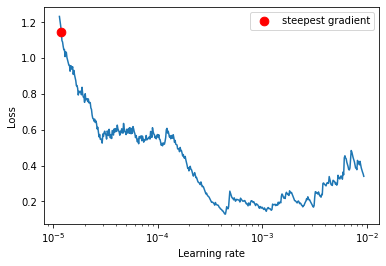

Training loss at epoch 1 - 0.128029200026067


{}
Valid loss at epoch 1 - 0.5821499864057619
saved checkpoint for epoch 1


Training loss at epoch 2 - 0.08682096738368274


{}
Valid loss at epoch 2 - 0.44921123160391435
saved checkpoint for epoch 2


Training loss at epoch 3 - 0.07432718403229956


{}
Valid loss at epoch 3 - 0.4388073392364444
saved checkpoint for epoch 3


Training loss at epoch 4 - 0.06828304807888344


{}
Valid loss at epoch 4 - 0.5211617530000453
saved checkpoint for epoch 4


Training loss at epoch 5 - 0.06487236623943317


{}
Valid loss at epoch 5 - 0.5044937229582241
saved checkpoint for epoch 5


Training loss at epoch 6 - 0.05912473040865734


{}
Valid loss at epoch 6 - 0.47423460471386814
saved checkpoint for epoch 6


Training loss at epoch 7 - 0.05479349128872855


{}
Valid loss at epoch 7 - 0.3931850648808236
saved checkpoint for epoch 7


Training loss at epoch 8 - 0.05067274908302352


{}
Valid loss at epoch 8 - 0.5052610047313632
saved checkpoint for epoch 8


Training loss at epoch 9 - 0.05464504285599105


{}
Valid loss at epoch 9 - 0.4765505786148869
saved checkpoint for epoch 9


Training loss at epoch 10 - 0.04881120252393885


{}
Valid loss at epoch 10 - 0.4679008749674778
saved checkpoint for epoch 10


Training loss at epoch 11 - 0.05094841755548259


{}
Valid loss at epoch 11 - 0.40944937175633955
saved checkpoint for epoch 11


Training loss at epoch 12 - 0.04430087623783038


{}
Valid loss at epoch 12 - 0.31787821540266886
saved checkpoint for epoch 12


Training loss at epoch 13 - 0.041738671326893385


{}
Valid loss at epoch 13 - 0.29882508280630016
saved checkpoint for epoch 13


Training loss at epoch 14 - 0.04083789472962963


{}
Valid loss at epoch 14 - 0.29400770130510234
saved checkpoint for epoch 14


Training loss at epoch 15 - 0.03621157549903728


{}
Valid loss at epoch 15 - 0.30612860027016425
saved checkpoint for epoch 15


Training loss at epoch 16 - 0.03439082850600244


{}
Valid loss at epoch 16 - 0.1971188737269567
saved checkpoint for epoch 16


Training loss at epoch 17 - 0.03226142945000902


{}
Valid loss at epoch 17 - 0.1800278121491476
saved checkpoint for epoch 17


Training loss at epoch 18 - 0.02804851645283634


{}
Valid loss at epoch 18 - 0.1790482172248315
saved checkpoint for epoch 18


Training loss at epoch 19 - 0.026256548210512848


{}
Valid loss at epoch 19 - 0.1846609309847866
saved checkpoint for epoch 19


Training loss at epoch 20 - 0.024779963620821945


{}
Valid loss at epoch 20 - 0.1858452939029251
saved checkpoint for epoch 20


Training loss at epoch 21 - 0.02266554670786718


{}
Valid loss at epoch 21 - 0.17743983264176214
saved checkpoint for epoch 21


Training loss at epoch 22 - 0.021271318126819094


{}
Valid loss at epoch 22 - 0.1713769432841515
saved checkpoint for epoch 22


Training loss at epoch 23 - 0.02040271258170833


{}
Valid loss at epoch 23 - 0.17972973622001556
saved checkpoint for epoch 23


Training loss at epoch 24 - 0.0200632141357346


{}
Valid loss at epoch 24 - 0.1832287610717574
saved checkpoint for epoch 24




Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.20E-05


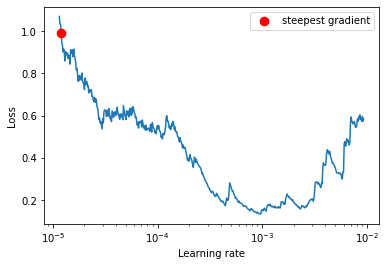

Training loss at epoch 1 - 0.19712148460093887


{}
Valid loss at epoch 1 - 0.6244232733638919
saved checkpoint for epoch 1


Training loss at epoch 2 - 0.08608499108464458


{}
Valid loss at epoch 2 - 0.3294236367302282
saved checkpoint for epoch 2


Training loss at epoch 3 - 0.05739533534506335


{}
Valid loss at epoch 3 - 0.2634241185626205
saved checkpoint for epoch 3


Training loss at epoch 4 - 0.05081960817275104


{}
Valid loss at epoch 4 - 0.22154102025895703
saved checkpoint for epoch 4


Training loss at epoch 5 - 0.04734898897935636


{}
Valid loss at epoch 5 - 0.24662833349133023
saved checkpoint for epoch 5


Training loss at epoch 6 - 0.04578645020461408


{}
Valid loss at epoch 6 - 0.23075980655088715
saved checkpoint for epoch 6


Training loss at epoch 7 - 0.04434481005591806


{}
Valid loss at epoch 7 - 0.21632718728209027
saved checkpoint for epoch 7


Training loss at epoch 8 - 0.041621849170187485


{}
Valid loss at epoch 8 - 0.22359467290189802
saved checkpoint for epoch 8


Training loss at epoch 9 - 0.0393372344103409


{}
Valid loss at epoch 9 - 0.22641223083649362
saved checkpoint for epoch 9


Training loss at epoch 10 - 0.03711287845726474


{}
Valid loss at epoch 10 - 0.2156048054445763
saved checkpoint for epoch 10


Training loss at epoch 11 - 0.03526047434585052


{}
Valid loss at epoch 11 - 0.19935090330486394
saved checkpoint for epoch 11


Training loss at epoch 12 - 0.033269597166217864


{}
Valid loss at epoch 12 - 0.20169853457078643
saved checkpoint for epoch 12


Training loss at epoch 13 - 0.03282999632006977


{}
Valid loss at epoch 13 - 0.16912683240157
saved checkpoint for epoch 13


Training loss at epoch 14 - 0.03159881395054981


{}
Valid loss at epoch 14 - 0.16897583600817895
saved checkpoint for epoch 14


Training loss at epoch 15 - 0.029726252810505685


{}
Valid loss at epoch 15 - 0.14234153795227103
saved checkpoint for epoch 15


Training loss at epoch 16 - 0.026998834057885685


{}
Valid loss at epoch 16 - 0.1411954205939356
saved checkpoint for epoch 16


Training loss at epoch 17 - 0.024277605452807622


{}
Valid loss at epoch 17 - 0.14252381218711332
saved checkpoint for epoch 17


Training loss at epoch 18 - 0.021814655921189113


{}
Valid loss at epoch 18 - 0.14466738864323314
saved checkpoint for epoch 18


Training loss at epoch 19 - 0.02007601405668538


{}
Valid loss at epoch 19 - 0.14721320913534383
saved checkpoint for epoch 19


Training loss at epoch 20 - 0.01802103157970123


{}
Valid loss at epoch 20 - 0.1290607808861045
saved checkpoint for epoch 20


Training loss at epoch 21 - 0.016601319490000606


{}
Valid loss at epoch 21 - 0.12101123565617873
saved checkpoint for epoch 21


Training loss at epoch 22 - 0.015849387745838613


{}
Valid loss at epoch 22 - 0.11903464710529969
saved checkpoint for epoch 22


Training loss at epoch 23 - 0.015164690171077381


{}
Valid loss at epoch 23 - 0.12708014407556276
saved checkpoint for epoch 23


Training loss at epoch 24 - 0.014692979380488396


{}
Valid loss at epoch 24 - 0.12746976144915942
saved checkpoint for epoch 24




Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.20E-05


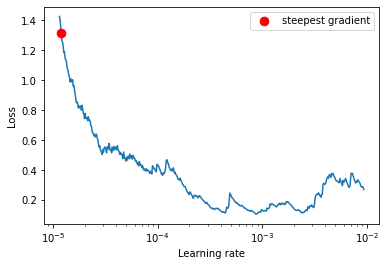

Training loss at epoch 1 - 0.11816513669211418


{}
Valid loss at epoch 1 - 0.647596615309618
saved checkpoint for epoch 1


Training loss at epoch 2 - 0.07997737544006668


{}
Valid loss at epoch 2 - 0.49043831290030965
saved checkpoint for epoch 2


Training loss at epoch 3 - 0.0661982594197616


{}
Valid loss at epoch 3 - 0.5629053465565856
saved checkpoint for epoch 3


Training loss at epoch 4 - 0.06008187389816158


{}
Valid loss at epoch 4 - 0.5097387618556315
saved checkpoint for epoch 4


Training loss at epoch 5 - 0.05613665439246688


{}
Valid loss at epoch 5 - 0.4562030538004272
saved checkpoint for epoch 5


Training loss at epoch 6 - 0.05196541824843734


{}
Valid loss at epoch 6 - 0.3348125548539113
saved checkpoint for epoch 6


Training loss at epoch 7 - 0.03800546849670354


{}
Valid loss at epoch 7 - 0.2686983787131553
saved checkpoint for epoch 7


Training loss at epoch 8 - 0.03968743357399944


{}
Valid loss at epoch 8 - 0.575148096498178
saved checkpoint for epoch 8


Training loss at epoch 9 - 0.033147489204420705


{}
Valid loss at epoch 9 - 0.3529767996194411
saved checkpoint for epoch 9


Training loss at epoch 10 - 0.03003903840028215


{}
Valid loss at epoch 10 - 0.3423913478547213
saved checkpoint for epoch 10


Training loss at epoch 11 - 0.026101061473164006


{}
Valid loss at epoch 11 - 0.24754212971548645
saved checkpoint for epoch 11


Training loss at epoch 12 - 0.02502448054932756


{}
Valid loss at epoch 12 - 0.1668826143580432
saved checkpoint for epoch 12


Training loss at epoch 13 - 0.022503564469807315


{}
Valid loss at epoch 13 - 0.14731694438627788
saved checkpoint for epoch 13


Training loss at epoch 14 - 0.020123596745252145


{}
Valid loss at epoch 14 - 0.15421741299939398
saved checkpoint for epoch 14


Training loss at epoch 15 - 0.01839362112834351


{}
Valid loss at epoch 15 - 0.12002698373885787
saved checkpoint for epoch 15


Training loss at epoch 16 - 0.017227105007332284


{}
Valid loss at epoch 16 - 0.10845687019885802
saved checkpoint for epoch 16


Training loss at epoch 17 - 0.016010645047645086


{}
Valid loss at epoch 17 - 0.09655790755107087
saved checkpoint for epoch 17


Training loss at epoch 18 - 0.015332793328561821


{}
Valid loss at epoch 18 - 0.10995528497258011
saved checkpoint for epoch 18


Training loss at epoch 19 - 0.014094157969229854


{}
Valid loss at epoch 19 - 0.11818957750742533
saved checkpoint for epoch 19


Training loss at epoch 20 - 0.011714532786863855


{}
Valid loss at epoch 20 - 0.11702446782087185
saved checkpoint for epoch 20


Training loss at epoch 21 - 0.010161361513746667


{}
Valid loss at epoch 21 - 0.11098148358263532
saved checkpoint for epoch 21


Training loss at epoch 22 - 0.00907161314287805


{}
Valid loss at epoch 22 - 0.10754059363460662
saved checkpoint for epoch 22


Training loss at epoch 23 - 0.008418126409233081


{}
Valid loss at epoch 23 - 0.11507468889182319
saved checkpoint for epoch 23


Training loss at epoch 24 - 0.008073610468272818


{}
Valid loss at epoch 24 - 0.11939849252147335
saved checkpoint for epoch 24



Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.43E-05


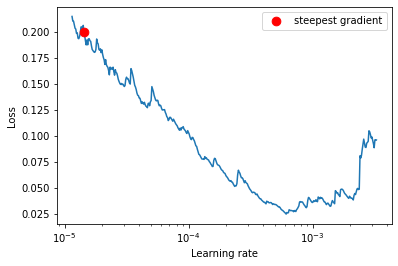

Training loss at epoch 1 - 0.14051756773144006


{}
Valid loss at epoch 1 - 0.25056701396801034
saved checkpoint for epoch 1


Training loss at epoch 2 - 0.05052860929165036


{}
Valid loss at epoch 2 - 0.20068614219068265
saved checkpoint for epoch 2


Training loss at epoch 3 - 0.03473739031935111


{}
Valid loss at epoch 3 - 0.1992471175154253
saved checkpoint for epoch 3


Training loss at epoch 4 - 0.03289796851808205


{}
Valid loss at epoch 4 - 0.2087881329412363
saved checkpoint for epoch 4


Training loss at epoch 5 - 0.03323392530728597


{}
Valid loss at epoch 5 - 0.22521881645127217
saved checkpoint for epoch 5


Training loss at epoch 6 - 0.0321263633100898


{}
Valid loss at epoch 6 - 0.1908035780854371
saved checkpoint for epoch 6


Training loss at epoch 7 - 0.03143449527793564


{}
Valid loss at epoch 7 - 0.2830349398510797
saved checkpoint for epoch 7


Training loss at epoch 8 - 0.03134415803942829


{}
Valid loss at epoch 8 - 0.19027122429439
saved checkpoint for epoch 8


Training loss at epoch 9 - 0.02767447483784053


{}
Valid loss at epoch 9 - 0.29833540738541253
saved checkpoint for epoch 9


Training loss at epoch 10 - 0.028427511437330397


{}
Valid loss at epoch 10 - 0.1545491282429014
saved checkpoint for epoch 10


Training loss at epoch 11 - 0.025658613189007154


{}
Valid loss at epoch 11 - 0.17461603279320562
saved checkpoint for epoch 11


Training loss at epoch 12 - 0.02440951434109593


{}
Valid loss at epoch 12 - 0.14544851044002843
saved checkpoint for epoch 12


Training loss at epoch 13 - 0.024137991573661564


{}
Valid loss at epoch 13 - 0.10658703696895011
saved checkpoint for epoch 13


Training loss at epoch 14 - 0.0242392485452001


{}
Valid loss at epoch 14 - 0.10843921836693676
saved checkpoint for epoch 14


Training loss at epoch 15 - 0.023454073419852645


{}
Valid loss at epoch 15 - 0.10549604474585883
saved checkpoint for epoch 15


Training loss at epoch 16 - 0.020055057939898688


{}
Valid loss at epoch 16 - 0.10834935339813938
saved checkpoint for epoch 16


Training loss at epoch 17 - 0.01807447286671959


{}
Valid loss at epoch 17 - 0.11150262320452199
saved checkpoint for epoch 17


Training loss at epoch 18 - 0.016406948916846888


{}
Valid loss at epoch 18 - 0.11957706218319279
saved checkpoint for epoch 18


Training loss at epoch 19 - 0.014584074563172181


{}
Valid loss at epoch 19 - 0.11876325415713447
saved checkpoint for epoch 19


Training loss at epoch 20 - 0.012852260308573022


{}
Valid loss at epoch 20 - 0.10753590879695756
saved checkpoint for epoch 20


Training loss at epoch 21 - 0.01186998811288504


{}
Valid loss at epoch 21 - 0.1004002309613386
saved checkpoint for epoch 21


Training loss at epoch 22 - 0.011149600101052783


{}
Valid loss at epoch 22 - 0.09599462613387376
saved checkpoint for epoch 22


Training loss at epoch 23 - 0.010644665097934193


{}
Valid loss at epoch 23 - 0.09996820229808895
saved checkpoint for epoch 23


Training loss at epoch 24 - 0.010236556504678447


{}
Valid loss at epoch 24 - 0.10048946972024075
saved checkpoint for epoch 24




Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.20E-05


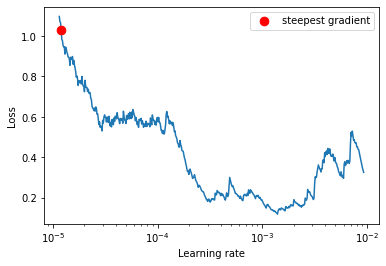

Training loss at epoch 1 - 0.12921050717588514


{}
Valid loss at epoch 1 - 0.6169916503891653
saved checkpoint for epoch 1


Training loss at epoch 2 - 0.09940357606974429


{}
Valid loss at epoch 2 - 0.41771024648024113
saved checkpoint for epoch 2


Training loss at epoch 3 - 0.07526389589882455


{}
Valid loss at epoch 3 - 0.3761181045247584
saved checkpoint for epoch 3


Training loss at epoch 4 - 0.0701498926995555


{}
Valid loss at epoch 4 - 0.48500911602560354
saved checkpoint for epoch 4


Training loss at epoch 5 - 0.0658732781233266


{}
Valid loss at epoch 5 - 0.4834409423020421
saved checkpoint for epoch 5


Training loss at epoch 6 - 0.06008740853110794


{}
Valid loss at epoch 6 - 0.40422837238530723
saved checkpoint for epoch 6


Training loss at epoch 7 - 0.06074712120229379


{}
Valid loss at epoch 7 - 0.34830421931585487
saved checkpoint for epoch 7


Training loss at epoch 8 - 0.05257536443532445


{}
Valid loss at epoch 8 - 0.37659542680699
saved checkpoint for epoch 8


Training loss at epoch 9 - 0.049359203439089464


{}
Valid loss at epoch 9 - 0.4218575302131322
saved checkpoint for epoch 9


Training loss at epoch 10 - 0.048431739300722254


{}
Valid loss at epoch 10 - 0.4075157598269229
saved checkpoint for epoch 10


Training loss at epoch 11 - 0.04575224540574709


{}
Valid loss at epoch 11 - 0.31956729558961733
saved checkpoint for epoch 11


Training loss at epoch 12 - 0.04544720842313836


{}
Valid loss at epoch 12 - 0.27141268760422055
saved checkpoint for epoch 12


Training loss at epoch 13 - 0.04604471969301813


{}
Valid loss at epoch 13 - 0.3286702863643972
saved checkpoint for epoch 13


Training loss at epoch 14 - 0.045482068768469615


{}
Valid loss at epoch 14 - 0.2403625707921325
saved checkpoint for epoch 14


Training loss at epoch 15 - 0.04212310067086947


{}
Valid loss at epoch 15 - 0.2379328587605637
saved checkpoint for epoch 15


Training loss at epoch 16 - 0.04292542932264041


{}
Valid loss at epoch 16 - 0.21627959688859327
saved checkpoint for epoch 16


Training loss at epoch 17 - 0.03934496011264855


{}
Valid loss at epoch 17 - 0.2092016033676206
saved checkpoint for epoch 17


Training loss at epoch 18 - 0.03609835466719232


{}
Valid loss at epoch 18 - 0.2101550979577765
saved checkpoint for epoch 18


Training loss at epoch 19 - 0.03377851337165339


{}
Valid loss at epoch 19 - 0.2195350738356308
saved checkpoint for epoch 19


Training loss at epoch 20 - 0.032139185679698125


{}
Valid loss at epoch 20 - 0.22160431748370127
saved checkpoint for epoch 20


Training loss at epoch 21 - 0.03057913819749956


{}
Valid loss at epoch 21 - 0.2143727726664166
saved checkpoint for epoch 21


Training loss at epoch 22 - 0.02910866550329956


{}
Valid loss at epoch 22 - 0.2076206078220691
saved checkpoint for epoch 22


Training loss at epoch 23 - 0.0279975465053576


{}
Valid loss at epoch 23 - 0.21391164975202814
saved checkpoint for epoch 23


Training loss at epoch 24 - 0.027413722524070178


{}
Valid loss at epoch 24 - 0.21598595835040418
saved checkpoint for epoch 24




Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.20E-05


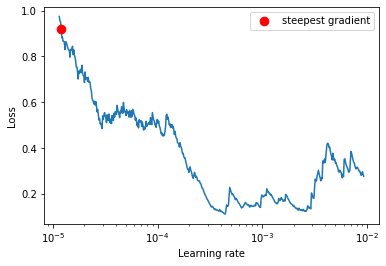

Training loss at epoch 1 - 0.1782547329296358


{}
Valid loss at epoch 1 - 0.5041429304650852
saved checkpoint for epoch 1


Training loss at epoch 2 - 0.0825658673979342


{}
Valid loss at epoch 2 - 0.29696364727403435
saved checkpoint for epoch 2


Training loss at epoch 3 - 0.06276945796678773


{}
Valid loss at epoch 3 - 0.24985268921116177
saved checkpoint for epoch 3


Training loss at epoch 4 - 0.05267925964435562


{}
Valid loss at epoch 4 - 0.2200757977457679
saved checkpoint for epoch 4


Training loss at epoch 5 - 0.046833241074346006


{}
Valid loss at epoch 5 - 0.3053976511772798
saved checkpoint for epoch 5


Training loss at epoch 6 - 0.0443203634134261


{}
Valid loss at epoch 6 - 0.22481660947811846
saved checkpoint for epoch 6


Training loss at epoch 7 - 0.04046159673307557


{}
Valid loss at epoch 7 - 0.24444054994656114
saved checkpoint for epoch 7


Training loss at epoch 8 - 0.03720435269526206


{}
Valid loss at epoch 8 - 0.2635713248912777
saved checkpoint for epoch 8


Training loss at epoch 9 - 0.03382457133004209


{}
Valid loss at epoch 9 - 0.24733536956565721
saved checkpoint for epoch 9


Training loss at epoch 10 - 0.03301430388703011


{}
Valid loss at epoch 10 - 0.19101032941621177
saved checkpoint for epoch 10


Training loss at epoch 11 - 0.02946444640750997


{}
Valid loss at epoch 11 - 0.21560228311893892
saved checkpoint for epoch 11


Training loss at epoch 12 - 0.030768275780137626


{}
Valid loss at epoch 12 - 0.13771382873231658
saved checkpoint for epoch 12


Training loss at epoch 13 - 0.02821096863219282


{}
Valid loss at epoch 13 - 0.12254325593156475
saved checkpoint for epoch 13


Training loss at epoch 14 - 0.026587937492877245


{}
Valid loss at epoch 14 - 0.10581203584312177
saved checkpoint for epoch 14


Training loss at epoch 15 - 0.024936920636391732


{}
Valid loss at epoch 15 - 0.09461161530367573
saved checkpoint for epoch 15


Training loss at epoch 16 - 0.02212846201931825


{}
Valid loss at epoch 16 - 0.09207125806382724
saved checkpoint for epoch 16


Training loss at epoch 17 - 0.021544933008844965


{}
Valid loss at epoch 17 - 0.09273127677413273
saved checkpoint for epoch 17


Training loss at epoch 18 - 0.01940292610175675


{}
Valid loss at epoch 18 - 0.09589110265428923
saved checkpoint for epoch 18


Training loss at epoch 19 - 0.018351823284756392


{}
Valid loss at epoch 19 - 0.1009108486908431
saved checkpoint for epoch 19


Training loss at epoch 20 - 0.015957347508810924


{}
Valid loss at epoch 20 - 0.09464390152038968
saved checkpoint for epoch 20


Training loss at epoch 21 - 0.014657735644723289


{}
Valid loss at epoch 21 - 0.09055677079120461
saved checkpoint for epoch 21


Training loss at epoch 22 - 0.013750555077858734


{}
Valid loss at epoch 22 - 0.08803301981213141
saved checkpoint for epoch 22


Training loss at epoch 23 - 0.01308100343507249


{}
Valid loss at epoch 23 - 0.09168509549784418
saved checkpoint for epoch 23


Training loss at epoch 24 - 0.012587897399498615


{}
Valid loss at epoch 24 - 0.0941138145494826
saved checkpoint for epoch 24




Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.18E-05


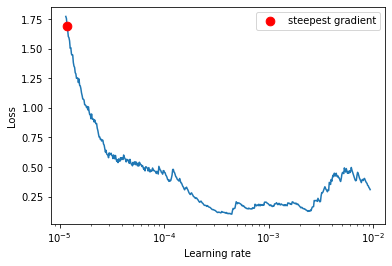

Training loss at epoch 1 - 0.14886774102109485


{}
Valid loss at epoch 1 - 0.6185739542148552
saved checkpoint for epoch 1


Training loss at epoch 2 - 0.09675980498665013


{}
Valid loss at epoch 2 - 0.3541331959470194
saved checkpoint for epoch 2


Training loss at epoch 3 - 0.07738345485529863


{}
Valid loss at epoch 3 - 0.4249293043905375
saved checkpoint for epoch 3


Training loss at epoch 4 - 0.06540311898163054


{}
Valid loss at epoch 4 - 0.40405940310079225
saved checkpoint for epoch 4


Training loss at epoch 5 - 0.059974928335577715


{}
Valid loss at epoch 5 - 0.4685170644400071
saved checkpoint for epoch 5


Training loss at epoch 6 - 0.04762172356189694


{}
Valid loss at epoch 6 - 0.31481859262804596
saved checkpoint for epoch 6


Training loss at epoch 7 - 0.04251309582847171


{}
Valid loss at epoch 7 - 0.19999173659907313
saved checkpoint for epoch 7


Training loss at epoch 8 - 0.03606291775708086


{}
Valid loss at epoch 8 - 0.23543680299605643
saved checkpoint for epoch 8


Training loss at epoch 9 - 0.030671671907766727


{}
Valid loss at epoch 9 - 0.30549788186136556
saved checkpoint for epoch 9


Training loss at epoch 10 - 0.028475651174958327


{}
Valid loss at epoch 10 - 0.34939163117384425
saved checkpoint for epoch 10


Training loss at epoch 11 - 0.030477002152765633


{}
Valid loss at epoch 11 - 0.18384480438366227
saved checkpoint for epoch 11


Training loss at epoch 12 - 0.025117383361794053


{}
Valid loss at epoch 12 - 0.16478286189388255
saved checkpoint for epoch 12


Training loss at epoch 13 - 0.025732516025018415


{}
Valid loss at epoch 13 - 0.16100746834156465
saved checkpoint for epoch 13


Training loss at epoch 14 - 0.02484733234276064


{}
Valid loss at epoch 14 - 0.14807453500677129
saved checkpoint for epoch 14


Training loss at epoch 15 - 0.018969762452761642


{}
Valid loss at epoch 15 - 0.11250251786289167
saved checkpoint for epoch 15


Training loss at epoch 16 - 0.017478311429731545


{}
Valid loss at epoch 16 - 0.11207793278581633
saved checkpoint for epoch 16


Training loss at epoch 17 - 0.016018307492195162


{}
Valid loss at epoch 17 - 0.10438669638290089
saved checkpoint for epoch 17


Training loss at epoch 18 - 0.014956713791179937


{}
Valid loss at epoch 18 - 0.1264871462647404
saved checkpoint for epoch 18


Training loss at epoch 19 - 0.01344787771377014


{}
Valid loss at epoch 19 - 0.12715568009535877
saved checkpoint for epoch 19


Training loss at epoch 20 - 0.011630685593991075


{}
Valid loss at epoch 20 - 0.11328844828721212
saved checkpoint for epoch 20


Training loss at epoch 21 - 0.010459681855572854


{}
Valid loss at epoch 21 - 0.10267776606262338
saved checkpoint for epoch 21


Training loss at epoch 22 - 0.009609333526459523


{}
Valid loss at epoch 22 - 0.10197645986490712
saved checkpoint for epoch 22


Training loss at epoch 23 - 0.009042390697286466


{}
Valid loss at epoch 23 - 0.11062680013781907
saved checkpoint for epoch 23


Training loss at epoch 24 - 0.008698658129142132


{}
Valid loss at epoch 24 - 0.11095975354617955
saved checkpoint for epoch 24



Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.15E-05


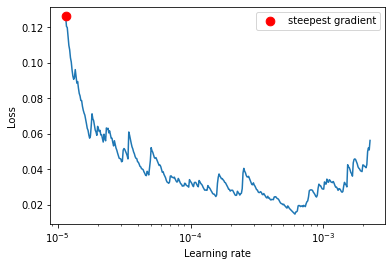

Training loss at epoch 1 - 0.06059197461931035


{}
Valid loss at epoch 1 - 0.18504224434418945
saved checkpoint for epoch 1


Training loss at epoch 2 - 0.032084893619176


{}
Valid loss at epoch 2 - 0.13402809132346694
saved checkpoint for epoch 2


Training loss at epoch 3 - 0.027478262404038105


{}
Valid loss at epoch 3 - 0.11492495637919221
saved checkpoint for epoch 3


Training loss at epoch 4 - 0.027300643395574295


{}
Valid loss at epoch 4 - 0.1484542047718958
saved checkpoint for epoch 4


Training loss at epoch 5 - 0.030383584204828368


{}
Valid loss at epoch 5 - 0.1505476313890243
saved checkpoint for epoch 5


Training loss at epoch 6 - 0.030888878888799806


{}
Valid loss at epoch 6 - 0.24882235446450662
saved checkpoint for epoch 6


Training loss at epoch 7 - 0.033518848126986994


{}
Valid loss at epoch 7 - 0.19564221936221027
saved checkpoint for epoch 7


Training loss at epoch 8 - 0.033301402351353315


{}
Valid loss at epoch 8 - 0.15632588144543827
saved checkpoint for epoch 8


Training loss at epoch 9 - 0.03004112302296562


{}
Valid loss at epoch 9 - 0.2316999455571783
saved checkpoint for epoch 9


Training loss at epoch 10 - 0.029162516025826337


{}
Valid loss at epoch 10 - 0.17851841750041564
saved checkpoint for epoch 10


Training loss at epoch 11 - 0.028400630928808825


{}
Valid loss at epoch 11 - 0.10570921608227857
saved checkpoint for epoch 11


Training loss at epoch 12 - 0.02593262278853217


{}
Valid loss at epoch 12 - 0.1348260612208016
saved checkpoint for epoch 12


Training loss at epoch 13 - 0.025760476471914442


{}
Valid loss at epoch 13 - 0.09487511006621074
saved checkpoint for epoch 13


Training loss at epoch 14 - 0.02284245016227942


{}
Valid loss at epoch 14 - 0.09336717837319082
saved checkpoint for epoch 14


Training loss at epoch 15 - 0.02219676815933781


{}
Valid loss at epoch 15 - 0.08944728149443257
saved checkpoint for epoch 15


Training loss at epoch 16 - 0.021728495420829858


{}
Valid loss at epoch 16 - 0.09185379207590405
saved checkpoint for epoch 16


Training loss at epoch 17 - 0.019925377047911752


{}
Valid loss at epoch 17 - 0.09076259306118804
saved checkpoint for epoch 17


Training loss at epoch 18 - 0.017729065586754588


{}
Valid loss at epoch 18 - 0.09498431155344053
saved checkpoint for epoch 18


Training loss at epoch 19 - 0.016395742250897453


{}
Valid loss at epoch 19 - 0.09419463755448862
saved checkpoint for epoch 19


Training loss at epoch 20 - 0.014838654162595048


{}
Valid loss at epoch 20 - 0.08756985669309388
saved checkpoint for epoch 20


Training loss at epoch 21 - 0.013795566495100501


{}
Valid loss at epoch 21 - 0.08381648834946813
saved checkpoint for epoch 21


Training loss at epoch 22 - 0.013150547670229572


{}
Valid loss at epoch 22 - 0.08244225255460763
saved checkpoint for epoch 22


Training loss at epoch 23 - 0.012470956261677203


{}
Valid loss at epoch 23 - 0.08619710132099535
saved checkpoint for epoch 23


Training loss at epoch 24 - 0.011947977614036064


{}
Valid loss at epoch 24 - 0.08764707662013112
saved checkpoint for epoch 24



In [ ]:
emb = 'biobert'

rnn = ['gru', 'lstm']
direction = ['uni', 'bi']
attention = ['w', 'wo']

for i in rnn:
  for j in direction:
    for k in attention:
      if i == 'gru':
        if j == 'uni':
          encoder = uni_gru_encoder
        elif j == 'bi':
          encoder = bi_gru_encoder
        if k == 'w':
          decoder = gru_w_decoder
        elif k == 'wo':
          decoder = gru_wo_decoder

        decoder = decoder.to(device)
        encoder = encoder.to(device)

        #create model
        model = GRUEncoderDecoderWrapper(
          encoder,
          decoder,
          output_size=n_out,
          teacher_forcing=0,
          sequence_len=n_in,
          decoder_input=True,
          device=device,
          attention= k == 'w'
          )

      if i == 'lstm':
        if j == 'uni':
          encoder = uni_lstm_encoder
        elif j == 'bi':
          encoder = bi_lstm_encoder
        if k == 'w':
          decoder = lstm_w_decoder
        elif k == 'wo':
          decoder = lstm_wo_decoder
        
        decoder = decoder.to(device)
        encoder = encoder.to(device)

        # create model
        model = LSTMEncoderDecoderWrapper(
          encoder,
          decoder,
          output_size=n_out,
          teacher_forcing=0,
          sequence_len=n_in,
          decoder_input=True,
          device=device,
          attention= k == 'w'
          )

      loss_function = nn.MSELoss()

      model = model.to(device)

      encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr=1e-3, weight_decay=1e-2)
      decoder_optimizer = torch.optim.AdamW(decoder.parameters(), lr=1e-3, weight_decay=1e-2)

      encoder_scheduler = optim.lr_scheduler.OneCycleLR(encoder_optimizer, max_lr=1e-3, steps_per_epoch=len(train_dataloader), epochs=24)
      decoder_scheduler = optim.lr_scheduler.OneCycleLR(decoder_optimizer, max_lr=1e-3, steps_per_epoch=len(train_dataloader), epochs=24)

      model_optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-2)

      trainer = TorchTrainer(
        'testall', #change the directory name for each model
        model, 
        [encoder_optimizer, decoder_optimizer], 
        loss_function, 
        [encoder_scheduler, decoder_scheduler],
        device, 
        scheduler_batch_step=True,
        pass_y=True
        )
      trainer.lr_find(train_dataloader, model_optimizer, start_lr=1e-5, end_lr=1e-2, num_iter=500)
      trainer.train(24, train_dataloader, test_dataloader, resume_only_model=False, resume=False)

      # get best validation
      my_dict = trainer.valid_losses
      key_min = min(my_dict.keys(), key=(lambda k: my_dict[k]))
      
      # write it  
      fields= ',' + i + '-' + j + '-' + k + ',' + emb + ',' + ',' + str(my_dict[key_min])

      with open(dir + 'stats.csv','a') as fd:
        fd.write(fields)
        fd.write("\n")

# **8. Inference**

Instantiate the trainer for the best model and load checkpoint if it exists. Otherwise train the model well the cell below and run the subsequent cells.

In [ ]:
# trainer.train(24, train_dataloader, test_dataloader, resume_only_model=False, resume=False)

In [ ]:
trainer._load_best_checkpoint()

loaded checkpoint for epoch - 22


In [ ]:
test_predictions = trainer.predict(test_dataloader)

In [ ]:
test.index = range(len(test))

In [ ]:
test['predictions'] = pd.Series(test_predictions.tolist())

In [ ]:
test['X'] = test['x_sequence'].apply(lambda x: x[:, 0])
test['Y'] = test['y_sequence'].apply(lambda x: x[:, 0])

# **9. Rescale data**

In [ ]:
def rescale_data(scale_map, data_df, columns=['predictions', 'y_sequence', 'x_sequence']):
    rescaled_data = pd.DataFrame()
    for country_id, item_data in tqdm(data_df.groupby('COUNTRY', as_index=False)):
        if country_id == '#NA#':
          continue
        mu = scale_map[country_id]['mu']
        sigma = scale_map[country_id]['sigma']
        for col in columns:
            item_data[col] = item_data[col].apply(lambda x: (np.array(x) * sigma) + mu)
        rescaled_data = pd.concat([rescaled_data, item_data], ignore_index=True)
    return rescaled_data

In [ ]:
'#NA#' in test.COUNTRY.unique()

False

In [ ]:
test_rescaled = rescale_data(scale_map, test, columns=['X', 'Y', 'predictions'])

In [ ]:
test = test_rescaled

# **10. Result Analysis**

In [ ]:
def plot_sequence_row(row, in_range=n_in, out_range=n_out):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(in_range)), y=row['X'],
                        mode='lines',
                        name='past data'))
    fig.add_trace(go.Scatter(x=list(range(in_range, in_range + out_range)), y=row['Y'],
                        mode='lines',
                        name='actual'))
    fig.add_trace(go.Scatter(x=list(range(in_range, in_range + out_range)), y=row['predictions'],
                        mode='lines',
                        name='predictions'))
    fig.show()

In [ ]:
test['predictions'] = test['predictions'].apply(np.array)

In [ ]:
def get_col_mean(group_data):
    agg_data = {}
    for col in group_data.columns:
        if col == 'ObservationDate':
            continue
        agg_data[col] = group_data[col].mean()
    return pd.Series(agg_data)

In [ ]:
date_predictions = test[['X', 'Y', 'predictions', 'ObservationDate']].groupby('ObservationDate').apply(get_col_mean)

In [ ]:
plot_sequence_row(date_predictions.iloc[-1])

# **11. Results**

In [ ]:
def generate_flat_df(sequence_data, predict_col='predictions', actual_col='Y'):
    flat_df = pd.DataFrame()
    for i, row in sequence_data.iterrows():
        row_df = pd.DataFrame()
        start_date = row['ObservationDate']
        row_df['ObservationDate'] = pd.date_range(start_date, periods=n_out).date.tolist()
        row_df['COUNTRY'] = row['COUNTRY']
        row_df['MEASURE'] = row['MEASURE']
        row_df['predictions'] = np.around(row[predict_col])
        if actual_col:
            row_df['Confirmed'] = np.around(row[actual_col])
        flat_df = pd.concat([flat_df, row_df], ignore_index=False)
    flat_df.index = range(len(flat_df))
    flat_df['ObservationDate'] = pd.to_datetime(flat_df['ObservationDate'])
    return flat_df

In [ ]:
test_sequence_data_sample = test[test['ObservationDate'] == '2021-02-23'] # after the train_split 2020-02-22 
test_with_MEASURE = test_with_MEASURE[test_with_MEASURE['ObservationDate'] == '2021-02-23']
test_sequence_data_sample['MEASURE'] = test_with_MEASURE['MEASURE'].tolist()
test_predict_df = generate_flat_df(test_sequence_data_sample)

In [ ]:
test_predict_df.head()

ObservationDate      COUNTRY  ... predictions  Confirmed
0      2021-02-23  Afghanistan  ...     59865.0    55644.0
1      2021-02-24  Afghanistan  ...     61727.0    55663.0
2      2021-02-25  Afghanistan  ...     62100.0    55682.0
3      2021-02-26  Afghanistan  ...     61971.0    55701.0
4      2021-02-27  Afghanistan  ...     61856.0    55701.0

[5 rows x 5 columns]

In [ ]:
def smape(y_pred, y_true):
    print(len(y_true))
    print(len(y_pred))
    denominator = (y_true + y_pred) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [ ]:
smape(test_predict_df['predictions'], test_predict_df['Confirmed'])

2730
2730


3.4297303303736064

In [ ]:
smape(np.round(test_predict_df['predictions']), test_predict_df['Confirmed'])

2730
2730


3.4297303303736064